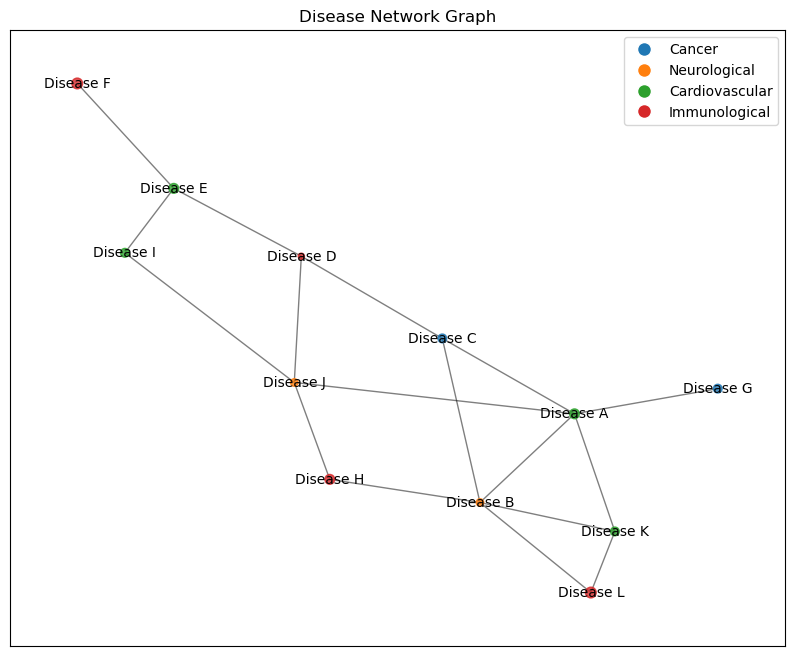

In [9]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Step 1: Create a Graph
G = nx.Graph()

# Add nodes with attributes (e.g., category and size)
G.add_node("Disease A", size=50, category="Cardiovascular")
G.add_node("Disease B", size=30, category="Neurological")
G.add_node("Disease C", size=40, category="Cancer")
G.add_node("Disease D", size=20, category="Immunological")
G.add_node("Disease E", size=50, category="Cardiovascular")
G.add_node("Disease F", size=60, category="Immunological")
G.add_node("Disease G", size=40, category="Cancer")
G.add_node("Disease H", size=50, category="Immunological")
G.add_node("Disease I", size=40, category="Cardiovascular")
G.add_node("Disease J", size=30, category="Neurological")
G.add_node("Disease K", size=40, category="Cardiovascular")
G.add_node("Disease L", size=60, category="Immunological")

# Add edges between nodes
G.add_edge("Disease A", "Disease B", weight=1)
G.add_edge("Disease A", "Disease C", weight=2)
G.add_edge("Disease B", "Disease C", weight=1)
G.add_edge("Disease C", "Disease D", weight=3)
G.add_edge("Disease E", "Disease D", weight=4)
G.add_edge("Disease F", "Disease E", weight=2)
G.add_edge("Disease G", "Disease A", weight=4)
G.add_edge("Disease H", "Disease J", weight=3)
G.add_edge("Disease I", "Disease J", weight=1)
G.add_edge("Disease J", "Disease D", weight=1)
G.add_edge("Disease K", "Disease A", weight=2)
G.add_edge("Disease L", "Disease B", weight=2)
G.add_edge("Disease H", "Disease B", weight=3)
G.add_edge("Disease I", "Disease E", weight=5)
G.add_edge("Disease J", "Disease A", weight=1)
G.add_edge("Disease K", "Disease B", weight=2)
G.add_edge("Disease L", "Disease K", weight=5)

# Step 2: Assign Node Attributes
categories = nx.get_node_attributes(G, 'category')
sizes = [G.nodes[node]['size'] for node in G.nodes]
unique_categories = list(set(categories.values()))

# Define a color map for categories
color_map = dict(zip(unique_categories, mcolors.TABLEAU_COLORS.keys()))
colors = [color_map[categories[node]] for node in G.nodes]

# Step 3: Draw the Graph
pos = nx.spring_layout(G, seed=42)  # Layout algorithm
plt.figure(figsize=(10, 8))

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=sizes, node_color=colors, alpha=0.8)

# Draw edges
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=10, font_color="black")

# Create a legend
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=mcolors.TABLEAU_COLORS[color], markersize=10, label=cat)
    for cat, color in color_map.items()
]
plt.legend(handles=legend_elements, loc='best')

# Show the plot
plt.title("Disease Network Graph")
plt.show()


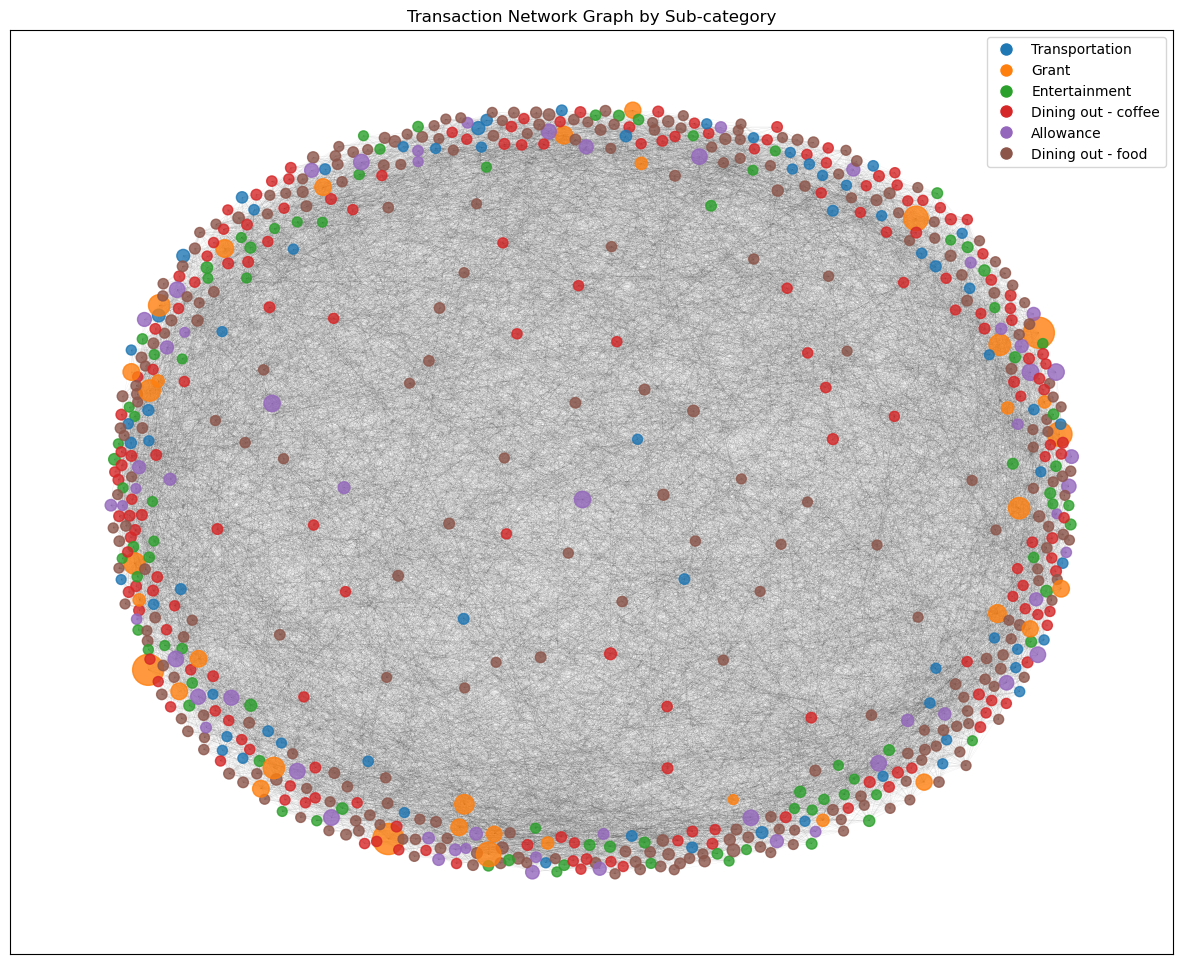

In [52]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np  # Add this import for logarithmic scaling


# Load the dataset
file_path = r'C:\Users\Lenovo\Desktop\DSA210_raw_Data\final_categorized_transactions.csv'
df = pd.read_csv(file_path)

# Convert 'Tarih' to datetime
df['Tarih'] = pd.to_datetime(df['Tarih']).dt.date

# Step 1: Create a graph
G = nx.Graph()

excluded_categories = {"Education", "Others", "ATM Use", "Savings", "Market  grocery", "Fashion"}  # Exclude these categories

# Step 2: Add nodes (each transaction is a node)
for index, row in df.iterrows():
    if row['Sub-category'] in excluded_categories or "Market" in row['Sub-category'] or "Cafeteria" in row['Sub-category']:
        continue
    node_id = f"Transaction_{index}"
    G.add_node(
        node_id,
        weight=abs(row['Tutar']),
        sub_category=row['Sub-category'],
        date=row['Tarih']
    )

# Step 3: Add general edges based on transaction proximity (same day or close days)
threshold_days = 3  # Define the threshold

category_factor_same = 2
category_factor_different = 1
alpha = 0.1  # Decay factor for temporal distance

# Store weights for normalization
all_weights = []

for i in range(len(df)):
    node1 = f"Transaction_{i}"
    if node1 not in G.nodes:
        continue  
    date1 = df.loc[i, 'Tarih']
    sub_category1 = df.loc[i, 'Sub-category']  # Sub-category of node1

    for j in range(i + 1, len(df)):
        node2 = f"Transaction_{j}"
        if node2 not in G.nodes:
            continue
        date2 = df.loc[j, 'Tarih']
        sub_category2 = df.loc[j, 'Sub-category']  # Sub-category of node2

        # Calculate the number of days between transactions
        days_diff = abs((date2 - date1).days)
        
        threshold = (category_factor_different * (1 / (days_diff + 1))) * (2.718 ** (-alpha * days_diff))
        if days_diff > threshold_days:
            threshold = 0  # Stop checking further if beyond the threshold
        same_month = 0
        if days_diff <= 15:
            same_month = 1
        same_sub_category = 0
        if sub_category1 == sub_category2:  # Check if the sub-categories are the same
            same_sub_category = 1
        
        # Calculate weight with decay
        weight = 0.7*(same_month)+ 0.06*threshold + 0.24*same_sub_category
        
        all_weights.append(weight)

        # Add an edge with weight based on proximity
        G.add_edge(node1, node2, weight=weight)


# Normalize node weights for visualization
node_weights = [G.nodes[node]['weight'] for node in G.nodes]
min_node_weight = min(node_weights)
max_node_weight = max(node_weights)

# Scale node weights to a range suitable for visualization
scaled_node_sizes = [
    50 + (w - min_node_weight) / (max_node_weight - min_node_weight) * 450
    for w in node_weights
]
        
        
# Step 5: Assign node attributes for visualization
categories = nx.get_node_attributes(G, 'sub_category')
unique_categories = list(set(categories.values()))

# Define a color map for categories
color_map = dict(zip(unique_categories, mcolors.TABLEAU_COLORS.keys()))
colors = [color_map.get(categories[node]) for node in G.nodes]

# Step 6: Draw the graph
pos = nx.spring_layout(G, seed=42, k=3, weight='weight')  # Layout algorithm to space nodes

plt.figure(figsize=(15, 12))

# Draw nodes with size based on weight
nx.draw_networkx_nodes(G, pos, node_size=scaled_node_sizes, node_color=colors, alpha=0.8)

# Define a weight threshold
weight_threshold = 0.6  # Adjust this value based on your needs

# Create a subgraph with edges that meet the weight threshold
filtered_edges = [(u, v) for u, v, d in G.edges(data=True) if d['weight'] >= weight_threshold]
filtered_graph = G.edge_subgraph(filtered_edges).copy()

# Draw edges
nx.draw_networkx_edges(
    filtered_graph,
    pos,
    width=0.08,  # Decrease edge thickness
    alpha=0.2  # Make edges more transparent
)

# Draw labels for sub-categories
nx.draw_networkx_labels(G, pos, labels={})

# Create a legend for sub-categories
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=mcolors.TABLEAU_COLORS[color], markersize=10, label=cat)
    for cat, color in color_map.items()
]
plt.legend(handles=legend_elements, loc='best')

# Show the graph
plt.title("Transaction Network Graph by Sub-category")
plt.show()


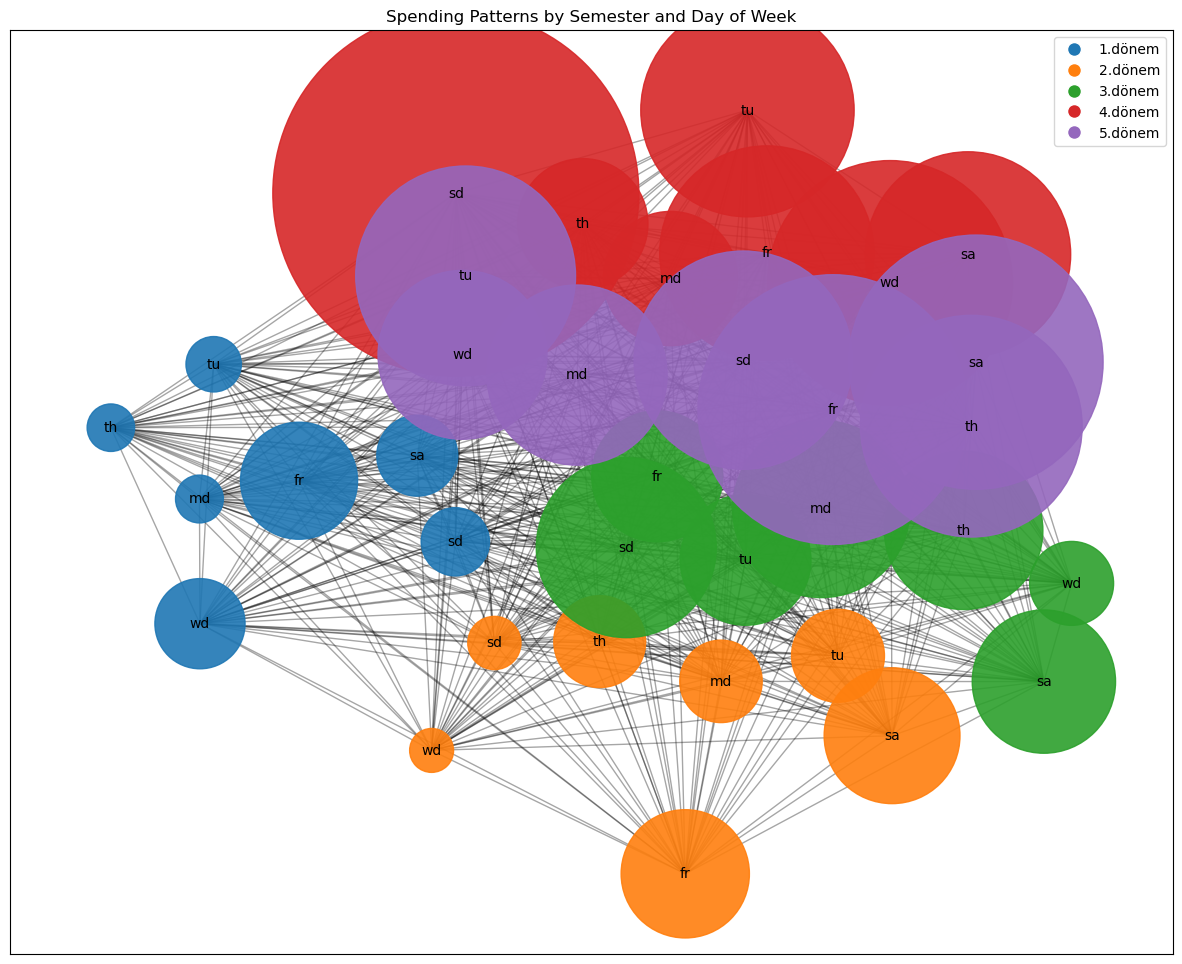

In [87]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from datetime import timedelta
import numpy as np  # For Gaussian similarity calculation

# Define abbreviations for the days of the week
day_abbreviations = {
    "Monday": "md",
    "Tuesday": "tu",
    "Wednesday": "wd",
    "Thursday": "th",
    "Friday": "fr",
    "Saturday": "sa",
    "Sunday": "sd",
}

# Define semesters and days of the week
semesters = {
    "1.d\u00f6nem": ("2022-11-01", "2023-01-21"),
    "2.d\u00f6nem": ("2023-02-16", "2023-06-14"),
    "3.d\u00f6nem": ("2023-10-01", "2024-01-27"),
    "4.d\u00f6nem": ("2024-02-15", "2024-06-14"),
    "5.d\u00f6nem": ("2024-09-25", "2024-12-14"),
}
days_of_week = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Define colors for each semester
semester_colors = dict(zip(semesters.keys(), mcolors.TABLEAU_COLORS.keys()))

# Load the dataset
file_path = r'C:\Users\Lenovo\Desktop\DSA210_raw_Data\final_categorized_merged.csv'
df = pd.read_csv(file_path)

# Convert 'Tarih' to datetime
df['Tarih'] = pd.to_datetime(df['Tarih'])

# Add a column for the day of the week
df['DayOfWeek'] = df['Tarih'].dt.day_name()

# Create the graph
G = nx.Graph()

# Process each semester
for semester, (start_date, end_date) in semesters.items():
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    
    # Filter transactions for the semester
    semester_df = df[(df['Tarih'] >= start_date) & (df['Tarih'] <= end_date)]
    
    # Calculate average total spending for each day of the week
    spending_by_day = semester_df.groupby('DayOfWeek')['Total Spending'].mean()
    discretionary_by_day = semester_df.groupby('DayOfWeek')['Share of Discretionary'].mean()
    
    for day in days_of_week:
        # Node ID
        day_abbreviation = day_abbreviations[day]
        
        # Node ID with abbreviated day name
        node_id = f"{semester}_{day_abbreviation}"
        
        # Node weight proportional to average total spending
        node_weight = spending_by_day.get(day, 0)
        
        # Add node to the graph
        G.add_node(node_id, weight=node_weight, discretionary_ratio=discretionary_by_day.get(day, 0), semester=semester, day=day)

# Scale node weights to make them very sensitive to subtle changes
node_weights = [G.nodes[node]['weight'] for node in G.nodes]
max_node_weight = max(node_weights) if node_weights else 1
scaled_node_sizes = [(weight / max_node_weight) ** 2 * 1000 for weight in node_weights]  # Squared scaling for sensitivity

# Add edges based on the updated rules
for node1 in G.nodes:
    for node2 in G.nodes:
        if node1 == node2:
            continue
        
        # Get node attributes
        semester1, day1 = G.nodes[node1]['semester'], G.nodes[node1]['day']
        semester2, day2 = G.nodes[node2]['semester'], G.nodes[node2]['day']
        discretionary1 = G.nodes[node1]['discretionary_ratio']
        discretionary2 = G.nodes[node2]['discretionary_ratio']
        
        # Calculate edge parameters
        same_day = int(day1 == day2)
        same_group = 0.3 if (day1 in ["Monday", "Tuesday", "Wednesday", "Thursday"] and day2 in ["Monday", "Tuesday", "Wednesday", "Thursday"]) or \
                               (day1 in ["Friday", "Saturday", "Sunday"] and day2 in ["Friday", "Saturday", "Sunday"]) else 0
        discretionary_diff = abs(discretionary1 - discretionary2)
        
        # Use a similarity function for discretionary ratio difference
        discretionary_similarity = np.exp(-discretionary_diff**2 / 0.01)  # Gaussian similarity function
        
        # Same semester effect
        same_semester = int(semester1 == semester2)
        
        # Edge weight
        edge_weight = (0.12 * same_day) + \
                      (0.05 * same_group) + \
                      (0.27 * discretionary_similarity) + \
                      (0.56 * same_semester)
        
        # Add edge to the graph
        G.add_edge(node1, node2, weight=edge_weight)

# Define colors for nodes based on semesters
colors = [semester_colors[G.nodes[node]['semester']] for node in G.nodes]

# Draw the graph
pos = nx.spring_layout(G, seed=42, k=0.1)

plt.figure(figsize=(15, 12))

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=scaled_node_sizes, node_color=colors, alpha=0.9)

# Add node labels with abbreviated day names
labels = {node: node.split("_")[1] for node in G.nodes}  # Extract day abbreviation from node ID
nx.draw_networkx_labels(G, pos, labels=labels, font_size=10, font_color="black")

# Draw edges
nx.draw_networkx_edges(G, pos, alpha=0.35, width=1)

# Add legend
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=mcolors.TABLEAU_COLORS[color], markersize=10, label=semester)
    for semester, color in semester_colors.items()
]
plt.legend(handles=legend_elements, loc='best')

plt.title("Spending Patterns by Semester and Day of Week")
plt.show()


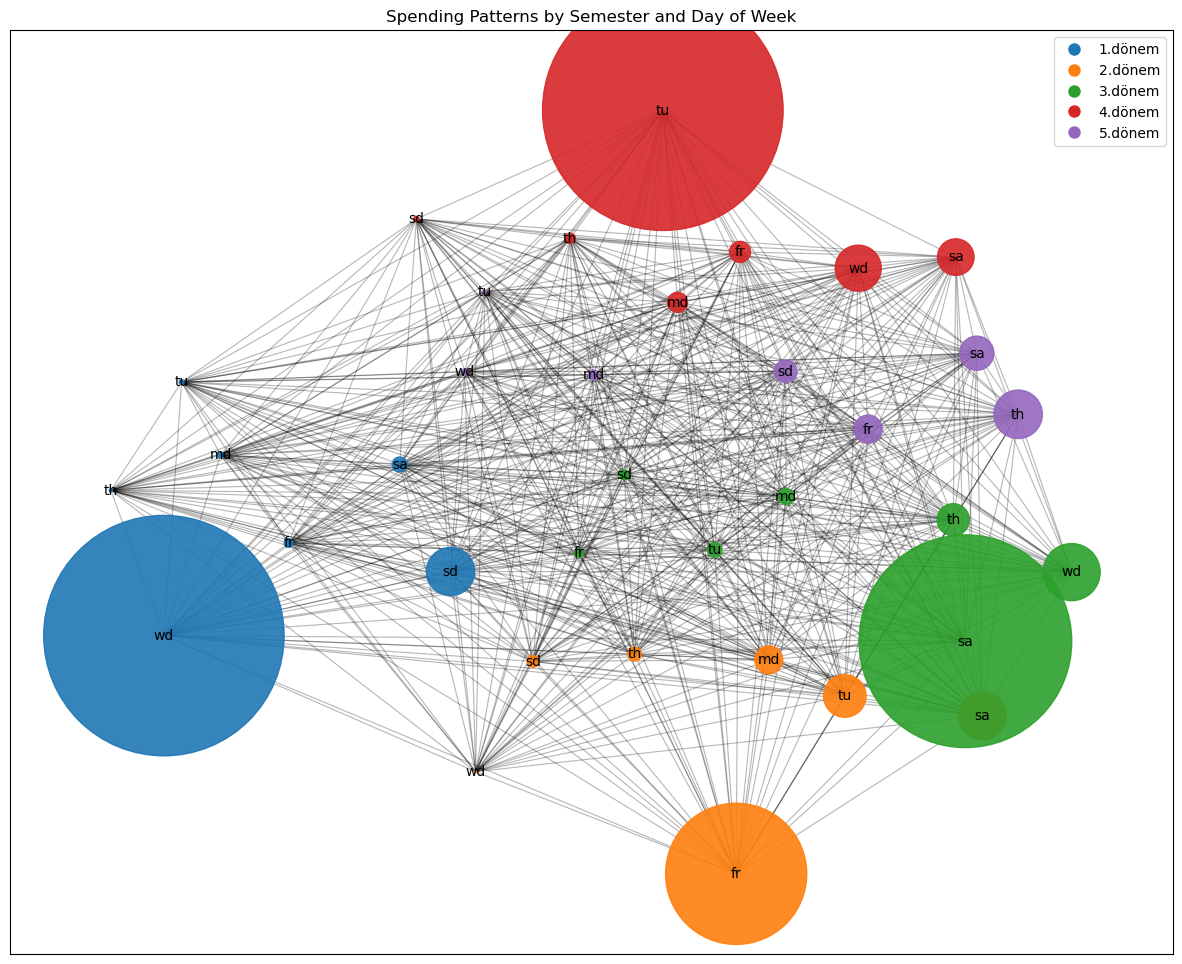

In [6]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from datetime import timedelta
import numpy as np  # For Gaussian similarity calculation

# Define abbreviations for the days of the week
day_abbreviations = {
    "Monday": "md",
    "Tuesday": "tu",
    "Wednesday": "wd",
    "Thursday": "th",
    "Friday": "fr",
    "Saturday": "sa",
    "Sunday": "sd",
}

# Define semesters and days of the week
semesters = {
    "1.d\u00f6nem": ("2022-11-01", "2023-01-21"),
    "2.d\u00f6nem": ("2023-02-16", "2023-06-14"),
    "3.d\u00f6nem": ("2023-10-01", "2024-01-27"),
    "4.d\u00f6nem": ("2024-02-15", "2024-06-14"),
    "5.d\u00f6nem": ("2024-09-25", "2024-12-14"),
}
days_of_week = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Define colors for each semester
semester_colors = dict(zip(semesters.keys(), mcolors.TABLEAU_COLORS.keys()))

# Load the dataset
file_path = r'C:\Users\Lenovo\Desktop\DSA210_raw_Data\final_categorized_merged.csv'
df = pd.read_csv(file_path)

# Convert 'Tarih' to datetime
df['Tarih'] = pd.to_datetime(df['Tarih'], format='%d.%m.%Y')

# Add a column for the day of the week
df['DayOfWeek'] = df['Tarih'].dt.day_name()

# Create the graph
G = nx.Graph()

# Process each semester
for semester, (start_date, end_date) in semesters.items():
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    
    # Filter transactions for the semester
    semester_df = df[(df['Tarih'] >= start_date) & (df['Tarih'] <= end_date)]
    
    # Calculate average total spending for each day of the week
    spending_by_day = semester_df.groupby('DayOfWeek')['Total Spending'].mean()
    discretionary_by_day = semester_df.groupby('DayOfWeek')['Share of Discretionary'].mean()
    
    for day in days_of_week:
        # Node ID
        day_abbreviation = day_abbreviations[day]
        
        # Node ID with abbreviated day name
        node_id = f"{semester}_{day_abbreviation}"
        
        # Node weight proportional to average total spending
        node_weight = discretionary_by_day.get(day, 0)
        
        # Add node to the graph
        G.add_node(node_id, weight=node_weight, discretionary_ratio=discretionary_by_day.get(day, 0), semester=semester, day=day)

# Scale node weights to make them drastically sensitive to subtle changes
node_weights = [G.nodes[node]['weight'] for node in G.nodes]
max_node_weight = max(node_weights) if node_weights else 1
scaled_node_sizes = [(weight / max_node_weight) ** 9 * 30000 for weight in node_weights]  # Eighth power scaling for extreme sensitivity

# Add edges based on the updated rules
for node1 in G.nodes:
    for node2 in G.nodes:
        if node1 == node2:
            continue
        
        # Get node attributes
        semester1, day1 = G.nodes[node1]['semester'], G.nodes[node1]['day']
        semester2, day2 = G.nodes[node2]['semester'], G.nodes[node2]['day']
        discretionary1 = G.nodes[node1]['discretionary_ratio']
        discretionary2 = G.nodes[node2]['discretionary_ratio']
        
        # Calculate edge parameters
        same_day = int(day1 == day2)
        same_group = 0.3 if (day1 in ["Monday", "Tuesday", "Wednesday", "Thursday"] and day2 in ["Monday", "Tuesday", "Wednesday", "Thursday"]) or \
                               (day1 in ["Friday", "Saturday", "Sunday"] and day2 in ["Friday", "Saturday", "Sunday"]) else 0
        discretionary_diff = abs(discretionary1 - discretionary2)
        
        # Use a similarity function for discretionary ratio difference
        discretionary_similarity = np.exp(-discretionary_diff**2 / 0.01)  # Gaussian similarity function
        
        # Same semester effect
        same_semester = int(semester1 == semester2)
        
        # Edge weight
        edge_weight = (0.12 * same_day) + \
                      (0.05 * same_group) + \
                      (0.27 * discretionary_similarity) + \
                      (0.56 * same_semester)
        
        # Add edge to the graph
        G.add_edge(node1, node2, weight=edge_weight)

# Define colors for nodes based on semesters
colors = [semester_colors[G.nodes[node]['semester']] for node in G.nodes]

# Draw the graph
pos = nx.spring_layout(G, seed=42, k=0.1)

plt.figure(figsize=(15, 12))

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=scaled_node_sizes, node_color=colors, alpha=0.9)

# Add node labels with abbreviated day names
labels = {node: node.split("_")[1] for node in G.nodes}  # Extract day abbreviation from node ID
nx.draw_networkx_labels(G, pos, labels=labels, font_size=10, font_color="black")

# Draw edges
nx.draw_networkx_edges(G, pos, alpha=0.28, width=0.83)

# Add legend
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=mcolors.TABLEAU_COLORS[color], markersize=10, label=semester)
    for semester, color in semester_colors.items()
]
plt.legend(handles=legend_elements, loc='best')

plt.title("Spending Patterns by Semester and Day of Week")
plt.show()


In [98]:
import pandas as pd

# Load the uploaded CSV file to see its contents
file_path = r'C:\Users\Lenovo\Desktop\DSA210_raw_Data\final_categorized_merged.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset to understand its structure
data.head()

# Convert the "Tarih" column to datetime for better handling
data['Tarih'] = pd.to_datetime(data['Tarih'])

# Extract the month and year in 'mm.yyyy' format for grouping
data['MonthYear'] = data['Tarih'].dt.strftime('%m.%Y')

# Group by 'MonthYear' and calculate the required averages and sums
monthly_data = data.groupby('MonthYear').agg({
    'Total Spending': 'sum',  # Sum of total spending
    'Share of Discretionary': 'mean'  # Average share of discretionary spending
}).reset_index()

# Rename columns for clarity
monthly_data.rename(columns={
    'Total Spending': 'Total Monthly Spending',
    'Share of Discretionary': 'Average Discretionary Share'
}, inplace=True)

# Save the prepared dataset to a CSV file
output_path = r'C:\Users\Lenovo\Desktop\DSA210_raw_Data\Monthly_Discretionary_Spending_Data.csv'
monthly_data.to_csv(output_path, index=False)

print(f"Processed data has been saved to: {output_path}")


Processed data has been saved to: C:\Users\Lenovo\Desktop\DSA210_raw_Data\Monthly_Discretionary_Spending_Data.csv


In [12]:
import pandas as pd

# Load the uploaded CSV file
file_path = r'C:\Users\Lenovo\Desktop\DSA210_raw_Data\final_categorized_merged.csv'
data = pd.read_csv(file_path)

# Convert the "Tarih" column to datetime for better handling
data['Tarih'] = pd.to_datetime(data['Tarih'], format='%d.%m.%Y')

# Extract the month and year in 'mm.yyyy' format for grouping
data['MonthYear'] = data['Tarih'].dt.strftime('%m.%Y')

# Group by 'MonthYear' and calculate the required averages and sums
monthly_data = data.groupby('MonthYear').agg({
    'Total Spending': 'sum',  # Sum of total spending
    'Share of Discretionary': 'mean'  # Average share of discretionary spending
}).reset_index()

# Rename columns for clarity
monthly_data.rename(columns={
    'Total Spending': 'Total Monthly Spending',
    'Share of Discretionary': 'Average Discretionary Share'
}, inplace=True)

# Sort by the date
monthly_data['Date'] = pd.to_datetime(monthly_data['MonthYear'], format='%m.%Y')
monthly_data = monthly_data.sort_values(by='Date').drop(columns=['Date'])

# Save the prepared dataset to a CSV file
output_path = r'C:\Users\Lenovo\Desktop\DSA210_raw_Data\Monthly_Discretionary_Spending_Data.csv'
monthly_data.to_csv(output_path, index=False)

print(f"Processed data has been saved to: {output_path}")


Processed data has been saved to: C:\Users\Lenovo\Desktop\DSA210_raw_Data\Monthly_Discretionary_Spending_Data.csv


In [13]:
"""
correlation coefficient
"""
from scipy.stats import pearsonr

# Extract the relevant columns for analysis
spending = monthly_data['Total Monthly Spending']
discretionary_share = monthly_data['Average Discretionary Share']

# Calculate Pearson correlation coefficient and p-value
correlation, p_value = pearsonr(spending, discretionary_share)

correlation, p_value


(0.1174261645459552, 0.6122084602151447)

In [21]:
import pandas as pd

# Sample data (replace this with your dataset)
data = pd.DataFrame({
    "MonthYear": ["11.2022", "12.2022", "1.2023", "2.2023", "3.2023", "4.2023", "5.2023", "6.2023",
                  "10.2023", "11.2023", "12.2023", "1.2024", "2.2024", "3.2024", "4.2024", "5.2024",
                  "6.2024", "9.2024", "10.2024", "11.2024", "12.2024"],
    "Total Monthly Spending": [-5867.77, -5931.62, -3598.29, -1396.89, -4271.04, -7820.96, -4621.27, -3384.98,
                               -10530.17, -8436.59, -11196.37, -10003.31, -13150.54, -12901.71, -9327.6, -18926.25,
                               -8308.65, -2290.78, -18610.51, -15349.67, -9447.42],
    "Average Discretionary Share": [0.47695, 0.43747, 0.41181, 0.49886, 0.44770, 0.51593, 0.56045, 0.45612,
                                    0.46867, 0.52511, 0.54103, 0.49353, 0.30851, 0.59489, 0.43131, 0.50505,
                                    0.59203, 0.49697, 0.38949, 0.46693, 0.51531]
})

# Convert MonthYear to datetime
data['MonthYear'] = pd.to_datetime(data['MonthYear'], format='%m.%Y', errors='coerce')

# Define semesters
semesters = {
    "1.dönem": ("2022-11-01", "2023-01-21"),
    "2.dönem": ("2023-02-16", "2023-06-14"),
    "3.dönem": ("2023-10-01", "2024-01-27"),
    "4.dönem": ("2024-02-15", "2024-06-14"),
    "5.dönem": ("2024-09-25", "2024-12-14")
}

# Assign semesters to rows
def assign_semester(date):
    for semester, (start, end) in semesters.items():
        if pd.to_datetime(start) <= date <= pd.to_datetime(end):
            return semester
    return None

data['Semester'] = data['MonthYear'].apply(assign_semester)

# Group by semester and calculate total spending and average discretionary share
semester_summary = data.groupby('Semester').agg({
    'Total Monthly Spending': 'sum',
    'Average Discretionary Share': 'mean'
}).reset_index()

# Rename columns for clarity
semester_summary.rename(columns={
    'Total Monthly Spending': 'Total Spending',
    'Average Discretionary Share': 'Average Discretionary Share'
}, inplace=True)

output_path = r'C:\Users\Lenovo\Desktop\Semester_Spending_Summary.csv'
semester_summary.to_csv(output_path, index=False)

output_path

'C:\\Users\\Lenovo\\Desktop\\Semester_Spending_Summary.csv'

In [23]:
"""
correlation coefficient
"""
from scipy.stats import pearsonr
import pandas as pd

# Load the semesters dataset
semester_data_path =  'C:\\Users\\Lenovo\\Desktop\\Semester_Spending_Summary.csv'

semester_data = pd.read_csv(semester_data_path)

# Extract the relevant columns for analysis
spending = semester_data['Total Spending']
discretionary_share = semester_data['Average Discretionary Share']

# Calculate Pearson correlation coefficient and p-value
correlation, p_value = pearsonr(spending, discretionary_share)

# Output the results
correlation, p_value



(-0.5689070256803843, 0.31687742685132503)

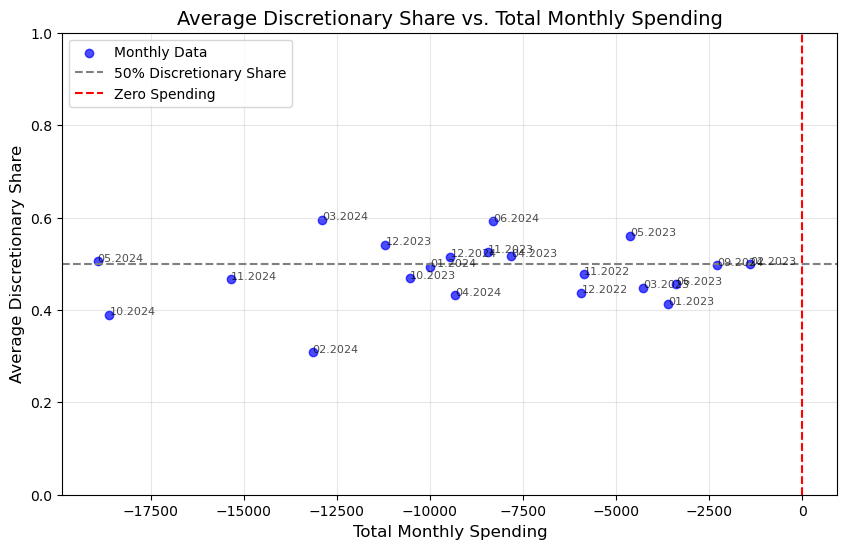

In [25]:
import matplotlib.pyplot as plt

# Extract data
spending = data['Total Monthly Spending']
discretionary_share = data['Average Discretionary Share']
months = data['MonthYear'].dt.strftime('%m.%Y')

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(spending, discretionary_share, color='blue', alpha=0.7, label="Monthly Data")
plt.title("Average Discretionary Share vs. Total Monthly Spending", fontsize=14)
plt.xlabel("Total Monthly Spending", fontsize=12)
plt.ylabel("Average Discretionary Share", fontsize=12)
plt.ylim(0, 1)  # Set y-axis limits from 0 to 1
for i, month in enumerate(months):
    plt.annotate(month, (spending.iloc[i], discretionary_share.iloc[i]), fontsize=8, alpha=0.7)
plt.axhline(y=0.5, color='gray', linestyle='--', label='50% Discretionary Share')
plt.axvline(x=0, color='red', linestyle='--', label='Zero Spending')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


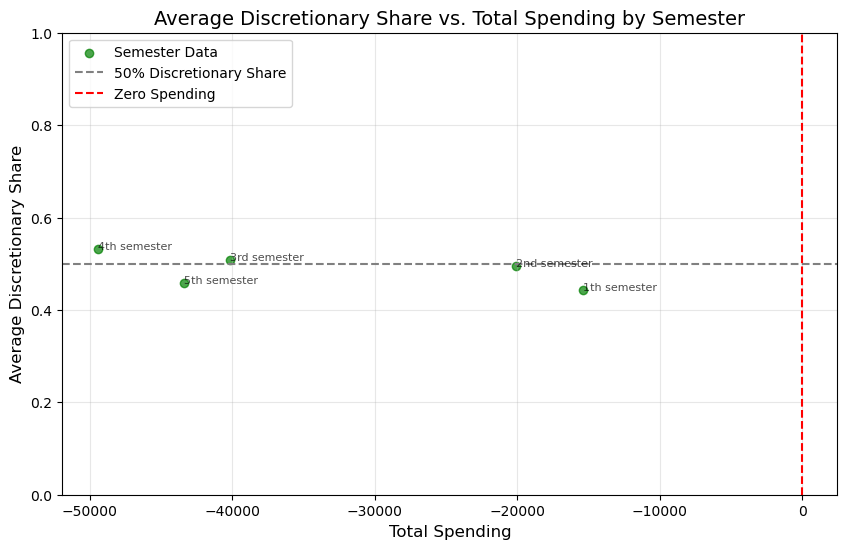

In [26]:
import matplotlib.pyplot as plt
import pandas as pd

# Example dataset
semester_data = pd.DataFrame({
    "Semester": ["1th semester", "2nd semester", "3rd semester", "4th semester", "5th semester"],
    "Total Spending": [-15397.68, -20098.25, -40166.44, -49464.21, -43407.6],
    "Average Discretionary Share": [0.442077, 0.49505, 0.507085, 0.53082, 0.457243]
})

# Extract data
spending = semester_data['Total Spending']
discretionary_share = semester_data['Average Discretionary Share']
semesters = semester_data['Semester']

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(spending, discretionary_share, color='green', alpha=0.7, label="Semester Data")
plt.title("Average Discretionary Share vs. Total Spending by Semester", fontsize=14)
plt.xlabel("Total Spending", fontsize=12)
plt.ylabel("Average Discretionary Share", fontsize=12)
plt.ylim(0, 1)  # Set y-axis limits from 0 to 1
for i, semester in enumerate(semesters):
    plt.annotate(semester, (spending.iloc[i], discretionary_share.iloc[i]), fontsize=8, alpha=0.7)
plt.axhline(y=0.5, color='gray', linestyle='--', label='50% Discretionary Share')
plt.axvline(x=0, color='red', linestyle='--', label='Zero Spending')
plt.legend()
plt.grid(alpha=0.3)
plt.show()
